<a href="https://colab.research.google.com/github/Aswini-J/Exp3-Sobel-edge-detection-filter-using-CUDA-to-enhance-the-performance-of-image-processing-tasks./blob/main/Sobel_edge_detection_image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc4jupyter

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-b6w3a4a7
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-b6w3a4a7
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 801584cceb559adc54e828ebe9b385c5f53fe70f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
The nvcc4jupyter extension is already loaded. To reload it, use:
  %reload_ext nvcc4jupyter


In [ ]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
%load_ext nvcc4jupyter

The nvcc4jupyter extension is already loaded. To reload it, use:
  %reload_ext nvcc4jupyter


In [ ]:
from pathlib import Path

file_path = Path('/absolute/path/to/images.jpeg')
if file_path.exists():
    print("File exists!")
else:
    print("File does not exist!")


File does not exist!


In [ ]:
import os
print("Current Working Directory:", os.getcwd())

Current Working Directory: /content


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving images.jpeg to images.jpeg


In [ ]:
from pathlib import Path

# Assuming the file is in the same directory as the notebook
file_path = Path('images.jpeg')
if file_path.exists():
    print("File exists!")
else:
    print("File does not exist!")


File exists!


In [ ]:
pwd


'/content'

In [ ]:
ls /content/images.jpeg

/content/images.jpeg


In [ ]:
#ls -l /content/images.jpeg
import cv2
image = cv2.imread('/content/images.jpeg')
if image is None:
    print("Error: Image not found or unable to read the image.")
else:
    print("Image read successfully.")


Image read successfully.


In [ ]:
%%writefile sobelEdgeDetectionFilter.cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda_runtime.h>
#include <opencv2/opencv.hpp>

using namespace cv;

__global__ void sobelFilter(unsigned char *srcImage, unsigned char *dstImage, unsigned int width, unsigned int height) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    float Kx[3][3] = { -1, 0, 1, -2, 0, 2, -1, 0, 1 };
    float Ky[3][3] = { 1, 2, 1, 0, 0, 0, -1, -2, -1 };

    // only threads inside image will write results
    if ((x >= 3 / 2) && (x < (width - 3 / 2)) && (y >= 3 / 2) && (y < (height - 3 / 2))) {
        // Gradient in x-direction
        float Gx = 0;
        // Loop inside the filter to average pixel values
        for (int ky = -3 / 2; ky <= 3 / 2; ky++) {
            for (int kx = -3 / 2; kx <= 3 / 2; kx++) {
                float fl = srcImage[((y + ky) * width + (x + kx))];
                Gx += fl * Kx[ky + 3 / 2][kx + 3 / 2];
            }
        }
        float Gx_abs = Gx < 0 ? -Gx : Gx;

        // Gradient in y-direction
        float Gy = 0;
        // Loop inside the filter to average pixel values
        for (int ky = -3 / 2; ky <= 3 / 2; ky++) {
            for (int kx = -3 / 2; kx <= 3 / 2; kx++) {
                float fl = srcImage[((y + ky) * width + (x + kx))];
                Gy += fl * Ky[ky + 3 / 2][kx + 3 / 2];
            }
        }
        float Gy_abs = Gy < 0 ? -Gy : Gy;

        dstImage[(y * width + x)] = Gx_abs + Gy_abs;
    }
}

void checkCudaErrors(cudaError_t r) {
    if (r != cudaSuccess) {
        fprintf(stderr, "CUDA Error: %s\n", cudaGetErrorString(r));
        exit(EXIT_FAILURE);
    }
}

int main() {
    // Read input image
    Mat image = imread("/content/images.jpeg", IMREAD_COLOR);

    if (image.empty()) {
        printf("Error: Image not found.\n");
        return -1;
    }

    int width = image.cols;
    int height = image.rows;
    size_t imageSize = width * height * sizeof(unsigned char);

    // Allocate host memory for output image
    unsigned char *h_outputImage = (unsigned char *)malloc(imageSize);
    if (h_outputImage == nullptr) {
        fprintf(stderr, "Failed to allocate host memory\n");
        return -1;
    }

    // Allocate device memory
    unsigned char *d_inputImage, *d_outputImage;
    checkCudaErrors(cudaMalloc(&d_inputImage, imageSize));
    checkCudaErrors(cudaMalloc(&d_outputImage, imageSize));
    checkCudaErrors(cudaMemcpy(d_inputImage, image.data, imageSize, cudaMemcpyHostToDevice));

    // Define CUDA events for timing
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    // Launch kernel
    dim3 blockSize(16, 16);
    dim3 gridSize(ceil(width / 16.0), ceil(height / 16.0));

    cudaEventRecord(start);
    sobelFilter<<<gridSize, blockSize>>>(d_inputImage, d_outputImage, width, height);
    cudaEventRecord(stop);

    // Synchronize events
    cudaEventSynchronize(stop);

    // Calculate elapsed time
    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);

    // Copy result back to host
    checkCudaErrors(cudaMemcpy(h_outputImage, d_outputImage, imageSize, cudaMemcpyDeviceToHost));

    // Write output image
    Mat outputImage(height, width, CV_8UC1, h_outputImage);
    imwrite("output_sobel.jpeg", outputImage);

    // Free memory
    free(h_outputImage);
    cudaFree(d_inputImage);
    cudaFree(d_outputImage);

    // Destroy CUDA events
    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    // Print elapsed time
    printf("Total time taken: %f milliseconds\n", milliseconds);

    return 0;
}


Writing sobelEdgeDetectionFilter.cu


In [ ]:
!nvcc -o sobelEdgeDetectionFilter sobelEdgeDetectionFilter.cu `pkg-config --cflags --libs opencv4`


/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [ ]:
!./sobelEdgeDetectionFilter

Total time taken: 118.108162 milliseconds


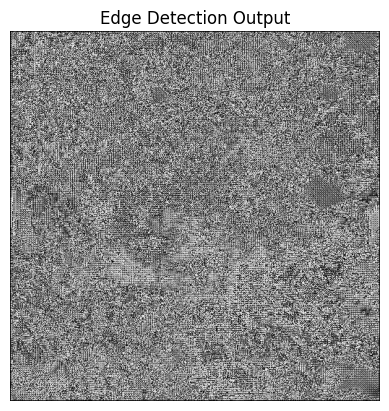

In [ ]:
import cv2
from matplotlib import pyplot as plt

# Read and display the output image
output_image_path = '/content/output_sobel.jpeg'
output_image = cv2.imread(output_image_path, cv2.IMREAD_GRAYSCALE)  # Use IMREAD_GRAYSCALE if it's a single-channel image

# Display the image
plt.imshow(output_image, cmap='gray')
plt.title('Edge Detection Output')
plt.axis('off')  # Hide the axes
plt.show()


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving images.jpeg to images (1).jpeg


In [ ]:
ls /content/images.jpeg

/content/images.jpeg


In [ ]:
%%writefile blur.cu
#include <opencv2/opencv.hpp>  // OpenCV header
#include <cuda_runtime.h>      // CUDA Runtime API
#include <device_launch_parameters.h> // CUDA device launch parameters
#include <cstdio>              // For printf and fprintf
#include <cstdlib>             // For exit and malloc

using namespace cv;

__global__ void boxFilter(unsigned char *srcImage, unsigned char *dstImage, unsigned int width, unsigned int height, int channel)
{
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    // Define a larger kernel size for increased blur intensity
    const int kernelSize = 20;
    const int halfKernelSize = kernelSize / 2;

    // only threads inside image will write results
    if ((x >= halfKernelSize) && (x < width - halfKernelSize) && (y >= halfKernelSize) && (y < height - halfKernelSize))
    {
        for (int c = 0; c < channel; c++)
        {
            // Sum of pixel values
            float sum = 0;
            // Number of filter pixels
            float kS = 0;
            // Loop inside the filter to average pixel values
            for (int ky = -halfKernelSize; ky <= halfKernelSize; ky++)
            {
                for (int kx = -halfKernelSize; kx <= halfKernelSize; kx++)
                {
                    float fl = srcImage[((y + ky) * width + (x + kx)) * channel + c];
                    sum += fl;
                    kS += 1;
                }
            }
            dstImage[(y * width + x) * channel + c] = sum / kS;
        }
    }
}

void checkCudaErrors(cudaError_t r)
{
    if (r != cudaSuccess)
    {
        fprintf(stderr, "CUDA Error: %s\n", cudaGetErrorString(r));
        exit(EXIT_FAILURE);
    }
}

int main()
{
    // Read input image
    Mat image = imread("images.jpeg", IMREAD_COLOR);
    if (image.empty())
    {
        printf("Error: Image not found.\n");
        return -1;
    }

    int width = image.cols;
    int height = image.rows;
    int channel = image.channels();
    size_t imageSize = width * height * channel * sizeof(unsigned char);

    // Allocate host memory for output image
    unsigned char *h_outputImage = (unsigned char *)malloc(imageSize);
    if (h_outputImage == nullptr)
    {
        fprintf(stderr, "Failed to allocate host memory\n");
        return -1;
    }

    // Allocate device memory
    unsigned char *d_inputImage, *d_outputImage;
    checkCudaErrors(cudaMalloc(&d_inputImage, imageSize));
    checkCudaErrors(cudaMalloc(&d_outputImage, imageSize));
    checkCudaErrors(cudaMemcpy(d_inputImage, image.data, imageSize, cudaMemcpyHostToDevice));

    // Define CUDA events for timing
    cudaEvent_t start, stop;
    checkCudaErrors(cudaEventCreate(&start));
    checkCudaErrors(cudaEventCreate(&stop));

    // Launch kernel
    dim3 blockSize(16, 16);
    dim3 gridSize((width + blockSize.x - 1) / blockSize.x, (height + blockSize.y - 1) / blockSize.y);

    checkCudaErrors(cudaEventRecord(start));
    boxFilter<<<gridSize, blockSize>>>(d_inputImage, d_outputImage, width, height, channel);
    checkCudaErrors(cudaEventRecord(stop));

    // Synchronize events
    checkCudaErrors(cudaEventSynchronize(stop));

    // Calculate elapsed time
    float milliseconds = 0;
    checkCudaErrors(cudaEventElapsedTime(&milliseconds, start, stop));

    // Copy result back to host
    checkCudaErrors(cudaMemcpy(h_outputImage, d_outputImage, imageSize, cudaMemcpyDeviceToHost));

    // Write output image
    Mat outputImage(height, width, CV_8UC3, h_outputImage);
    imwrite("output_blur.jpeg", outputImage);

    // Free memory
    free(h_outputImage);
    cudaFree(d_inputImage);
    cudaFree(d_outputImage);

    // Destroy CUDA events
    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    // Print elapsed time
    printf("Total time taken: %f milliseconds\n", milliseconds);

    return 0;
}


Overwriting blur.cu


In [ ]:
!nvcc -o blur blur.cu `pkg-config --cflags --libs opencv4` && ./blur

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

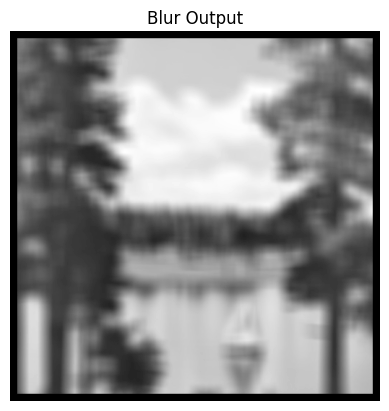

In [ ]:
import cv2
from matplotlib import pyplot as plt

# Read and display the output image
output_image_path = '/content/output_blur.jpeg'
output_image = cv2.imread(output_image_path, cv2.IMREAD_GRAYSCALE)  # Use IMREAD_GRAYSCALE if it's a single-channel image

# Display the image
plt.imshow(output_image, cmap='gray')
plt.title('Blur Output')
plt.axis('off')  # Hide the axes
plt.show()

In [ ]:
%%writefile blur.c
#include <opencv2/opencv.hpp>  // OpenCV header for image processing
#include <cstdio>              // For printf and fprintf
#include <cstdlib>             // For malloc and free
#include <sys/time.h>

using namespace cv;

void boxFilter(unsigned char *srcImage, unsigned char *dstImage, int width, int height, int channel) {
    // Define a larger kernel size for increased blur intensity
    const int kernelSize = 20;
    const int halfKernelSize = kernelSize / 2;

    for (int y = halfKernelSize; y < height - halfKernelSize; y++) {
        for (int x = halfKernelSize; x < width - halfKernelSize; x++) {
            for (int c = 0; c < channel; c++) {
                float sum = 0;
                float kS = 0;
                for (int ky = -halfKernelSize; ky <= halfKernelSize; ky++) {
                    for (int kx = -halfKernelSize; kx <= halfKernelSize; kx++) {
                        float fl = srcImage[((y + ky) * width + (x + kx)) * channel + c];
                        sum += fl;
                        kS += 1;
                    }
                }
                dstImage[(y * width + x) * channel + c] = sum / kS;
            }
        }
    }
}

int main() {
    // Read input image
    Mat image = imread("images.jpeg", IMREAD_COLOR);
    if (image.empty()) {
        printf("Error: Image not found.\n");
        return -1;
    }

    int width = image.cols;
    int height = image.rows;
    int channel = image.channels();
    size_t imageSize = width * height * channel * sizeof(unsigned char);

    // Allocate memory for output image
    unsigned char *outputImage = (unsigned char *)malloc(imageSize);
    if (outputImage == nullptr) {
        fprintf(stderr, "Failed to allocate memory\n");
        return -1;
    }

    // Convert input image to grayscale and copy data to input buffer
    unsigned char *inputImage = image.data;

    // Timing
    struct timeval start, end;
    gettimeofday(&start, NULL);

    // Apply box filter
    boxFilter(inputImage, outputImage, width, height, channel);

    // Timing
    gettimeofday(&end, NULL);
    float elapsed = (end.tv_sec - start.tv_sec) * 1000.0; // sec to ms
    elapsed += (end.tv_usec - start.tv_usec) / 1000.0;   // us to ms

    // Write output image
    Mat output(height, width, CV_8UC3, outputImage);
    imwrite("output_blur_cpu.jpeg", output);

    // Free memory
    free(outputImage);

    // Print elapsed time
    printf("Total time taken: %f milliseconds\n", elapsed);

    return 0;
}


Writing blur.c


In [ ]:
!g++ -o blurC blur.c `pkg-config --cflags --libs opencv4` && ./blurC

Total time taken: 1294.718018 milliseconds


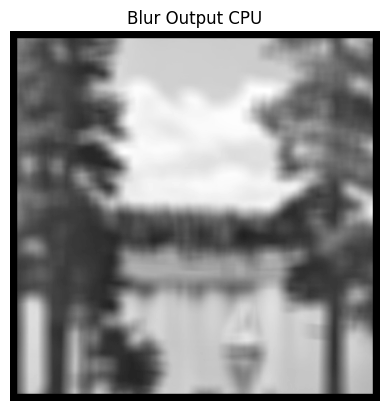

In [ ]:
import cv2
from matplotlib import pyplot as plt

# Read and display the output image
output_image_path = '/content/output_blur_cpu.jpeg'
output_image = cv2.imread(output_image_path, cv2.IMREAD_GRAYSCALE)  # Use IMREAD_GRAYSCALE if it's a single-channel image

# Display the image
plt.imshow(output_image, cmap='gray')
plt.title('Blur Output CPU')
plt.axis('off')  # Hide the axes
plt.show()

In [ ]:
%%writefile sharpening.cu
#include <opencv2/opencv.hpp>  // OpenCV header for image processing
#include <cuda_runtime.h>      // CUDA Runtime API
#include <device_launch_parameters.h> // CUDA device launch parameters
#include <cstdio>              // For printf and fprintf
#include <cstdlib>             // For exit and malloc

using namespace cv;

__global__ void sharpeningFilter(unsigned char *srcImage, unsigned char *dstImage, unsigned int width, unsigned int height, int channel)
{
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    float kernel[3][3] = {{-1, -1, -1}, {-1, 9, -1}, {-1, -1, -1}};

    // only threads inside image will write results
    if ((x >= 1) && (x < width - 1) && (y >= 1) && (y < height - 1))
    {
        for (int c = 0; c < channel; c++)
        {
            // Sum of pixel values
            float sum = 0;
            // Loop inside the filter to apply the kernel
            for (int ky = -1; ky <= 1; ky++)
            {
                for (int kx = -1; kx <= 1; kx++)
                {
                    float fl = srcImage[((y + ky) * width + (x + kx)) * channel + c];
                    sum += fl * kernel[ky + 1][kx + 1];
                }
            }
            dstImage[(y * width + x) * channel + c] = sum;
        }
    }
}

void checkCudaErrors(cudaError_t r)
{
    if (r != cudaSuccess)
    {
        fprintf(stderr, "CUDA Error: %s\n", cudaGetErrorString(r));
        exit(EXIT_FAILURE);
    }
}

int main()
{
    // Read input image
    Mat image = imread("images.jpeg", IMREAD_GRAYSCALE);
    if (image.empty())
    {
        printf("Error: Image not found.\n");
        return -1;
    }

    int width = image.cols;
    int height = image.rows;
    int channel = image.channels();
    size_t imageSize = width * height * sizeof(unsigned char);

    // Allocate host memory for output image
    unsigned char *h_outputImage = (unsigned char *)malloc(imageSize);
    if (h_outputImage == nullptr)
    {
        fprintf(stderr, "Failed to allocate host memory\n");
        return -1;
    }

    // Allocate device memory
    unsigned char *d_inputImage, *d_outputImage;
    checkCudaErrors(cudaMalloc(&d_inputImage, imageSize));
    checkCudaErrors(cudaMalloc(&d_outputImage, imageSize));
    checkCudaErrors(cudaMemcpy(d_inputImage, image.data, imageSize, cudaMemcpyHostToDevice));

    // Define CUDA events for timing
    cudaEvent_t start, stop;
    checkCudaErrors(cudaEventCreate(&start));
    checkCudaErrors(cudaEventCreate(&stop));

    // Launch kernel
    dim3 blockSize(16, 16);
    dim3 gridSize((width + blockSize.x - 1) / blockSize.x, (height + blockSize.y - 1) / blockSize.y);

    checkCudaErrors(cudaEventRecord(start));
    sharpeningFilter<<<blockSize,gridSize>>>(d_inputImage, d_outputImage, width, height, channel);
    checkCudaErrors(cudaEventRecord(stop));

    // Synchronize events
    checkCudaErrors(cudaEventSynchronize(stop));

    // Calculate elapsed time
    float milliseconds = 0;
    checkCudaErrors(cudaEventElapsedTime(&milliseconds, start, stop));

    // Copy result back to host
    checkCudaErrors(cudaMemcpy(h_outputImage, d_outputImage, imageSize, cudaMemcpyDeviceToHost));

    // Write output image
    Mat outputImage(height, width, CV_8UC1, h_outputImage);
    imwrite("output_sharpened.jpeg", outputImage);

    // Free memory
    free(h_outputImage);
    cudaFree(d_inputImage);
    cudaFree(d_outputImage);

    // Destroy CUDA events
    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    // Print elapsed time
    printf("Total time taken: %f milliseconds\n", milliseconds);

    return 0;
}


Overwriting sharpening.cu


In [ ]:
!nvcc -o sharpening sharpening.cu `pkg-config --cflags --libs opencv4` && ./sharpening


/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

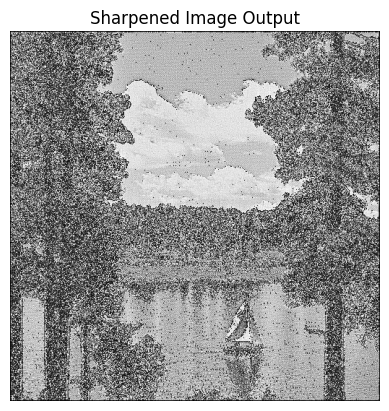

In [ ]:
import cv2
from matplotlib import pyplot as plt

# Read and display the output image
output_image_path = '/content/output_sharpened.jpeg'
output_image = cv2.imread(output_image_path, cv2.IMREAD_GRAYSCALE)  # Use IMREAD_GRAYSCALE if it's a single-channel image

# Display the image
plt.imshow(output_image, cmap='gray')
plt.title('Sharpened Image Output')
plt.axis('off')  # Hide the axes
plt.show()

In [ ]:
%%writefile sharpening.c
#include <opencv2/opencv.hpp>  // OpenCV header for image processing
#include <cstdio>              // For printf and fprintf
#include <cstdlib>             // For malloc and free
#include <ctime>               // For clock and CLOCKS_PER_SEC

using namespace cv;

void sharpeningFilter(unsigned char *srcImage, unsigned char *dstImage, unsigned int width, unsigned int height, int channel)
{
    float kernel[3][3] = {{-1, -1, -1}, {-1, 9, -1}, {-1, -1, -1}};

    for (int y = 1; y < height - 1; ++y)
    {
        for (int x = 1; x < width - 1; ++x)
        {
            for (int c = 0; c < channel; ++c)
            {
                float sum = 0;
                for (int ky = -1; ky <= 1; ++ky)
                {
                    for (int kx = -1; kx <= 1; ++kx)
                    {
                        float fl = srcImage[((y + ky) * width + (x + kx)) * channel + c];
                        sum += fl * kernel[ky + 1][kx + 1];
                    }
                }
                dstImage[(y * width + x) * channel + c] = sum;
            }
        }
    }
}

int main()
{
    Mat image = imread("images.jpeg", IMREAD_GRAYSCALE);
    if (image.empty())
    {
        printf("Error: Image not found.\n");
        return -1;
    }

    int width = image.cols;
    int height = image.rows;
    int channel = image.channels();
    size_t imageSize = width * height * sizeof(unsigned char);

    unsigned char *h_outputImage = (unsigned char *)malloc(imageSize);
    if (h_outputImage == nullptr)
    {
        fprintf(stderr, "Failed to allocate host memory\n");
        return -1;
    }

    unsigned char *inputImage = image.data;

    // Define CPU events for timing
    clock_t start, end;
    double cpu_time_used;

    // Start time
    start = clock();

    // Apply sharpening filter
    sharpeningFilter(inputImage, h_outputImage, width, height, channel);

    // End time
    end = clock();

    // Calculate elapsed time
    cpu_time_used = ((double)(end - start)) / CLOCKS_PER_SEC * 1000.0;

    // Write output image
    Mat outputImage(height, width, CV_8UC1, h_outputImage);
    imwrite("output_sharpened.jpeg", outputImage);

    // Free memory
    free(h_outputImage);

    // Print elapsed time
    printf("Total time taken: %f milliseconds\n", cpu_time_used);

    return 0;
}

Writing sharpening.c


In [ ]:
!g++ -o sharpening sharpening.c `pkg-config --cflags --libs opencv4` -std=c++11 && ./sharpening

Total time taken: 37.075000 milliseconds


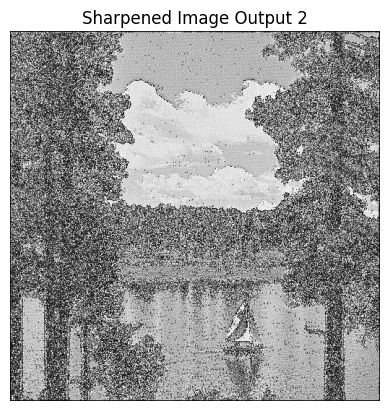

In [ ]:
import cv2
from matplotlib import pyplot as plt

# Read and display the output image
output_image_path = '/content/output_sharpened.jpeg'
output_image = cv2.imread(output_image_path, cv2.IMREAD_GRAYSCALE)  # Use IMREAD_GRAYSCALE if it's a single-channel image

# Display the image
plt.imshow(output_image, cmap='gray')
plt.title('Sharpened Image Output 2')
plt.axis('off')  # Hide the axes
plt.show()

In [ ]:
%%writefile red.cu
#include <opencv2/opencv.hpp>  // OpenCV header for image processing
#include <cuda_runtime.h>      // CUDA Runtime API
#include <device_launch_parameters.h> // CUDA device launch parameters
#include <cstdio>              // For printf and fprintf
#include <cstdlib>             // For malloc and free

using namespace cv;

__global__ void redChannelManipulation(unsigned char *srcImage, unsigned char *dstImage, unsigned int width, unsigned int height)
{
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    // only threads inside image will write results
    if ((x >= 0) && (x < width) && (y >= 0) && (y < height))
    {
        // Get the red channel value
        unsigned char red = srcImage[(y * width + x) * 3 + 2]; // BGR ordering: red channel is at index 2

        // Modify the red channel value (for example, increasing its intensity)
        // You can apply any desired manipulation here
        red = min(255, red * 2); // Example: doubling the intensity, capped at 255

        // Write the modified red channel value to the output image
        dstImage[(y * width + x) * 3 + 2] = red; // BGR ordering: red channel is at index 2
    }
}

void checkCudaErrors(cudaError_t r) {
    if (r != cudaSuccess) {
        fprintf(stderr, "CUDA Error: %s\n", cudaGetErrorString(r));
        exit(EXIT_FAILURE);
    }
}

int main() {
    // Read input image
    Mat image = imread("images.jpeg", IMREAD_COLOR);
    if (image.empty()) {
        printf("Error: Image not found.\n");
        return -1;
    }
    int width = image.cols;
    int height = image.rows;
    size_t imageSize = width * height * 3 * sizeof(unsigned char); // 3 channels (BGR)

    unsigned char *h_outputImage = (unsigned char *)malloc(imageSize);
    if (h_outputImage == nullptr) {
        fprintf(stderr, "Failed to allocate host memory\n");
        return -1;
    }

    unsigned char *d_inputImage, *d_outputImage;
    checkCudaErrors(cudaMalloc(&d_inputImage, imageSize));
    checkCudaErrors(cudaMalloc(&d_outputImage, imageSize));
    checkCudaErrors(cudaMemcpy(d_inputImage, image.data, imageSize, cudaMemcpyHostToDevice));

    // Define CUDA events for timing
    cudaEvent_t start, stop;
    checkCudaErrors(cudaEventCreate(&start));
    checkCudaErrors(cudaEventCreate(&stop));

    // Launch kernel
    dim3 blockSize(16, 16);
    dim3 gridSize((width + blockSize.x - 1) / blockSize.x, (height + blockSize.y - 1) / blockSize.y);

    checkCudaErrors(cudaEventRecord(start));
    redChannelManipulation<<<blockSize,gridSize>>>(d_inputImage, d_outputImage, width, height);
    checkCudaErrors(cudaEventRecord(stop));

    // Synchronize events
    checkCudaErrors(cudaEventSynchronize(stop));

    // Calculate elapsed time
    float milliseconds = 0;
    checkCudaErrors(cudaEventElapsedTime(&milliseconds, start, stop));

    // Copy result back to host
    checkCudaErrors(cudaMemcpy(h_outputImage, d_outputImage, imageSize, cudaMemcpyDeviceToHost));

    // Write output image
    Mat outputImage(height, width, CV_8UC3, h_outputImage); // 3 channels (BGR)
    imwrite("output_red_modified.jpeg", outputImage);

    // Free memory
    free(h_outputImage);
    cudaFree(d_inputImage);
    cudaFree(d_outputImage);

    // Destroy CUDA events
    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    // Print elapsed time
    printf("Total time taken: %f milliseconds\n", milliseconds);

    return 0;
}

Overwriting red.cu


In [ ]:
!nvcc -o red red.cu `pkg-config --cflags --libs opencv4` && ./red

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

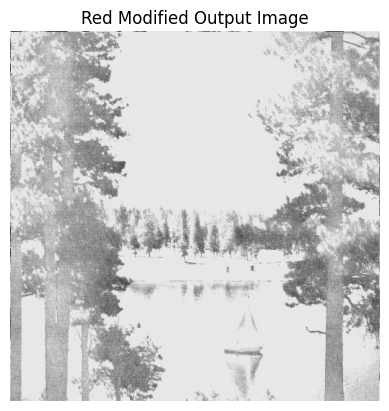

In [ ]:
import cv2
from matplotlib import pyplot as plt

# Read and display the output image
output_image_path = '/content/output_red_modified.jpeg'
output_image = cv2.imread(output_image_path, cv2.IMREAD_GRAYSCALE)  # Use IMREAD_GRAYSCALE if it's a single-channel image

# Display the image
plt.imshow(output_image, cmap='gray')
plt.title('Red Modified Output Image')
plt.axis('off')  # Hide the axes
plt.show()

In [ ]:
%%writefile red.c
#include <opencv2/opencv.hpp>  // OpenCV header for image processing
#include <cstdio>              // For printf and fprintf
#include <cstdlib>             // For malloc and free
#include <algorithm>           // For std::min
#include <ctime>               // For clock and timing
using namespace cv;

void redChannelManipulation(unsigned char *srcImage, unsigned char *dstImage, unsigned int width, unsigned int height)
{
    for (int y = 0; y < height; ++y)
    {
        for (int x = 0; x < width; ++x)
        {
            // Get the red channel value
            unsigned char red = srcImage[(y * width + x) * 3 + 2]; // BGR ordering: red channel is at index 2

            // Modify the red channel value (for example, increasing its intensity)
            // You can apply any desired manipulation here
            red = std::min(255, red * 2); // Example: doubling the intensity, capped at 255

            // Write the modified red channel value to the output image
            dstImage[(y * width + x) * 3 + 2] = red; // BGR ordering: red channel is at index 2
        }
    }
}

int main()
{
    // Read input image
    Mat image = imread("images.jpeg", IMREAD_COLOR);
    if (image.empty())
    {
        printf("Error: Image not found.\n");
        return -1;
    }
    int width = image.cols;
    int height = image.rows;
    size_t imageSize = width * height * 3 * sizeof(unsigned char); // 3 channels (BGR)

    unsigned char *h_outputImage = (unsigned char *)malloc(imageSize);
    if (h_outputImage == nullptr)
    {
        fprintf(stderr, "Failed to allocate host memory\n");
        return -1;
    }

    // Define CPU time variables
    clock_t start, end;
    double cpu_time_used;

    start = clock(); // Start measuring CPU time

    // Perform red channel manipulation
    redChannelManipulation(image.data, h_outputImage, width, height);

    end = clock(); // Stop measuring CPU time

    cpu_time_used = ((double)(end - start)) / CLOCKS_PER_SEC * 1000.0; // Calculate CPU time in milliseconds

    // Write output image
    Mat outputImage(height, width, CV_8UC3, h_outputImage); // 3 channels (BGR)
    imwrite("output_red_modified.jpeg", outputImage);

    // Free memory
    free(h_outputImage);

    // Print elapsed time
    printf("Total time taken: %f milliseconds\n", cpu_time_used);

    return 0;
}


Overwriting red.c


In [ ]:
!g++ -o red red.c `pkg-config --cflags --libs opencv4` && ./red

Total time taken: 6.523000 milliseconds


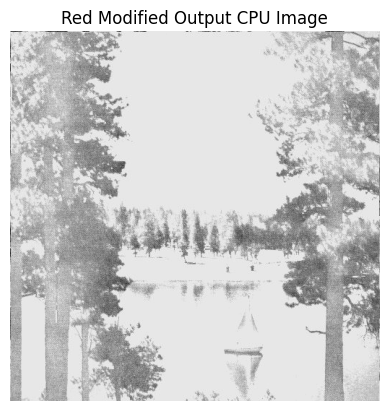

In [ ]:
import cv2
from matplotlib import pyplot as plt

# Read and display the output image
output_image_path = '/content/output_red_modified.jpeg'
output_image = cv2.imread(output_image_path, cv2.IMREAD_GRAYSCALE)  # Use IMREAD_GRAYSCALE if it's a single-channel image

# Display the image
plt.imshow(output_image, cmap='gray')
plt.title('Red Modified Output CPU Image')
plt.axis('off')  # Hide the axes
plt.show()

In [ ]:

!g++ -o red red.c `pkg-config --cflags --libs opencv4` && ./red

Total time taken: 6.966000 milliseconds


In [ ]:
!./red


Total time taken: 6.526000 milliseconds


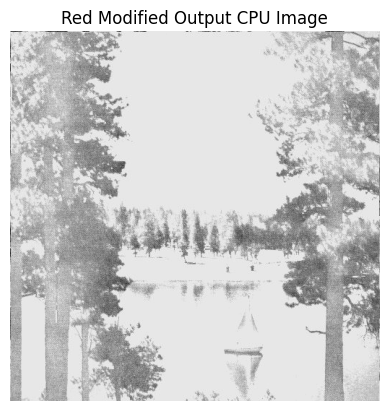

In [ ]:
import cv2
from matplotlib import pyplot as plt

# Read and display the output image
output_image_path = '/content/output_red_modified.jpeg'
output_image = cv2.imread(output_image_path, cv2.IMREAD_GRAYSCALE)  # Use IMREAD_GRAYSCALE if it's a single-channel image

# Display the image
plt.imshow(output_image, cmap='gray')
plt.title('Red Modified Output CPU Image')
plt.axis('off')  # Hide the axes
plt.show()